In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import glob # Can be useful but we use os

In [2]:
SIZE = 320
BATCH_SIZE = 32
CHANNELS = 1
PATCH_SIZE = 48
PATCH_DIM = (PATCH_SIZE ** 2) * CHANNELS
GENDER_FEATURE_SHAPE = (1,)
EPOCHS = 35
LEARNING_RATE = 1e-3

OVERLAP = 0.25
STRIDE = int(PATCH_SIZE * (1 - OVERLAP))
num_patches_per_side = (SIZE - PATCH_SIZE) // STRIDE + 1
N_PATCHES = num_patches_per_side ** 2

INPUT_SHAPE = (N_PATCHES, PATCH_DIM)



In [3]:
base_dir = '.'

train_csv_path = os.path.join(base_dir, 'Train', 'train_labels.csv')
val_csv_path = os.path.join(base_dir, 'Val', 'val_labels.csv')
test_csv_path = os.path.join(base_dir, 'Test', 'test_labels.csv')

train_image_dir = os.path.join(base_dir, 'Train', 'train_samples_pp')
val_image_dir = os.path.join(base_dir, 'Val', 'val_samples_pp')
test_image_dir = os.path.join(base_dir, 'Test', 'test_samples_pp')

checkpoint_filepath = 'Models/bid_RNN.keras'

def load_labels(csv_path):
    df = pd.read_csv(csv_path, index_col='id')
    df = df[['boneage', 'male']].rename(columns={'male': 'gender'})
    df['gender'] = df['gender'].astype(np.float32)
    df['boneage'] = df['boneage'].astype(np.float32)
    return df

In [4]:
def create_dataframe(image_dir, labels_df):
    data = []

    for filename in os.listdir(image_dir):
        file_id = int(filename.split('.')[0])
        if file_id in labels_df.index:
            boneage = labels_df.loc[file_id, 'boneage']
            gender = labels_df.loc[file_id, 'gender']
            full_path = os.path.join(image_dir, filename)
            data.append({'file_path': full_path, 'boneage': boneage, 'gender': gender})

    return pd.DataFrame(data)


def preprocess_image(image, labels):
    image = tf.image.resize(image, [SIZE, SIZE])
    if image.shape[-1] is None:
        image = tf.reshape(image, [SIZE, SIZE, CHANNELS])
    elif image.shape[-1] != CHANNELS:
        image = tf.image.rgb_to_grayscale(image)

    image = tf.cast(image, tf.float32) / 255.0

    patches = tf.image.extract_patches(
        images=tf.expand_dims(image, 0),
        sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
        strides=[1, STRIDE,    STRIDE,    1],
        rates=[1, 1, 1, 1],
        padding='VALID',
    )
    patches = tf.reshape(patches, (1, N_PATCHES, PATCH_DIM))
    patches = tf.squeeze(patches, axis=0)

    #- new
    boneage, gender = labels
    boneage = (boneage - mean_age) / std_age
    return patches, (boneage, gender)
    #-


def image_label_generator(file_paths, boneage_labels, gender_labels):
    for path, boneage, gender in zip(file_paths, boneage_labels, gender_labels):
        img_bytes = tf.io.read_file(path)
        image = tf.io.decode_image(img_bytes, channels=CHANNELS, expand_animations=False)
        image.set_shape([None, None, CHANNELS])
        yield image, (boneage, gender)


def create_tf_dataset(dataframe, shuffle, repeat_flag, batch_size_local=BATCH_SIZE):
    dataset = tf.data.Dataset.from_generator(
        image_label_generator,
        args=[
            dataframe['file_path'].values,
            dataframe['boneage'].values,
            dataframe['gender'].values],
        output_signature=(
            tf.TensorSpec(shape=(None, None, CHANNELS), dtype=tf.uint8),
            (tf.TensorSpec(shape=(), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.float32))))

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(lambda img, labels: ((img, labels[1]), labels[0]),
                          num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)

    if repeat_flag:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size_local)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [5]:
train_labels_df = load_labels(train_csv_path)
val_labels_df = load_labels(val_csv_path)
test_labels_df = load_labels(test_csv_path)

#- exclusive for this
mean_age = train_labels_df['boneage'].mean()
std_age  = train_labels_df['boneage'].std()
#-

training_dataframe = create_dataframe(train_image_dir, train_labels_df)
validation_dataframe = create_dataframe(val_image_dir, val_labels_df)
test_dataframe = create_dataframe(test_image_dir, test_labels_df)

train_dataset = create_tf_dataset(training_dataframe, shuffle=True, repeat_flag=True)
validation_dataset = create_tf_dataset(validation_dataframe, shuffle=False, repeat_flag=False)
test_dataset_eval = create_tf_dataset(test_dataframe, shuffle=False, repeat_flag=False)

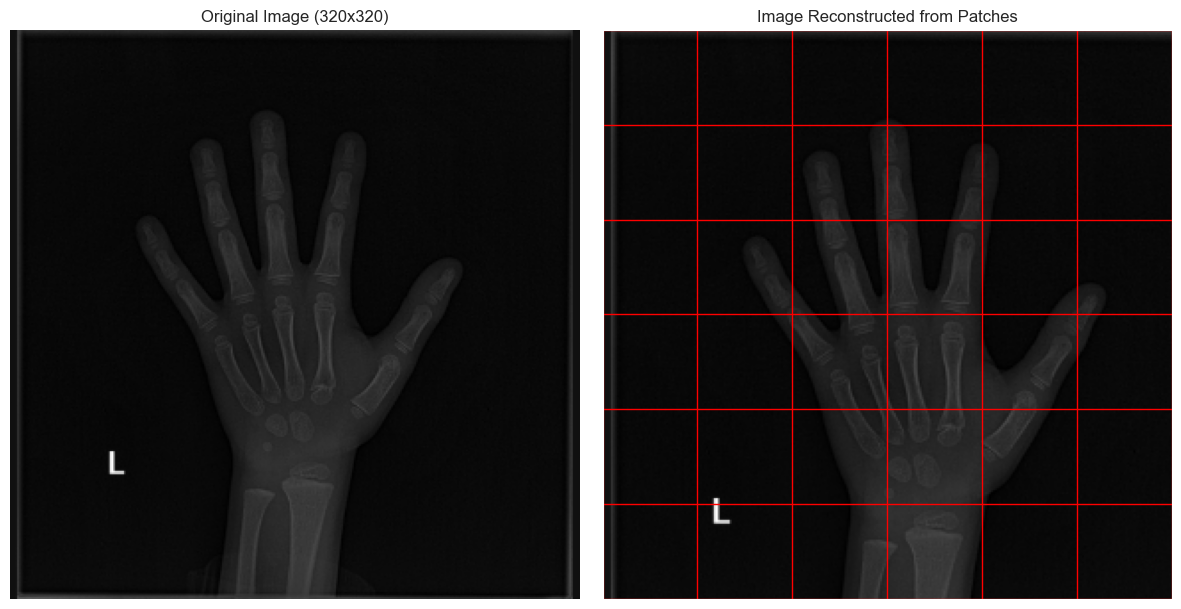

In [6]:
sample_row = test_dataframe.iloc[3]
image_path = sample_row['file_path']
img_bytes = tf.io.read_file(image_path)
image = tf.io.decode_image(img_bytes, channels=CHANNELS, expand_animations=False)
image_resized = tf.image.resize(image, [SIZE, SIZE])
image_resized_float = tf.cast(image_resized, tf.float32) / 255.0

patches_tensor = tf.image.extract_patches(
images=tf.expand_dims(image_resized_float, 0),
sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
strides=[1, PATCH_SIZE, PATCH_SIZE, 1],
rates=[1, 1, 1, 1],
padding='VALID',
)

num_patches_per_side = SIZE // PATCH_SIZE
patches_reshaped = tf.reshape(patches_tensor, [num_patches_per_side, num_patches_per_side, PATCH_SIZE, PATCH_SIZE, CHANNELS])
patches_np = patches_reshaped.numpy()

rows = []
for i in range(num_patches_per_side):
    row = np.concatenate(patches_np[i, :, :, :, :], axis=1)
    rows.append(row)
    patch_grid_image = np.concatenate(rows, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image_resized_float.numpy().squeeze(), cmap='gray')
ax1.set_title(f'Original Image ({SIZE}x{SIZE})')
ax1.axis('off')

ax2.imshow(patch_grid_image.squeeze(), cmap='gray')
ax2.set_title(f'Image Reconstructed from Patches')
ax2.grid(True, which='both', color='red', linestyle='-', linewidth=1)
ax2.set_xticks(np.arange(-.5, SIZE, PATCH_SIZE))
ax2.set_yticks(np.arange(-.5, SIZE, PATCH_SIZE))
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(length=0)

plt.tight_layout()
plt.show()

In [7]:
def bid_RNN(input_shape, gender_shape,
                       patch_size=PATCH_SIZE, channels=CHANNELS,
                       patch_embed_dim=112, rnn_units=[112, 112, 56]):
    # 1) Inputs & reshape
    image_input  = keras.Input(shape=input_shape,  name="image_input")
    gender_input = keras.Input(shape=gender_shape, name="gender_input")
    num_patches, patch_dim = input_shape
    x = layers.Reshape((num_patches, patch_size, patch_size, channels),
                       name="reshape_patches")(image_input)

    # 2) Smaller Conv2D patch encoder
    patch_encoder = keras.Sequential([
        layers.Conv2D(32, kernel_size=4, padding="same", activation="relu"),
        layers.Flatten(),
        layers.Dense(patch_embed_dim, activation="relu"),
    ], name="patch_encoder")
    x = layers.TimeDistributed(patch_encoder, name="patch_embedding")(x)

    # 3) Positional embeddings
    pos_indices = tf.range(num_patches, dtype=tf.int32)
    pos_emb_layer = layers.Embedding(input_dim=num_patches,
                                     output_dim=patch_embed_dim,
                                     name="pos_embedding")
    pos_emb = tf.expand_dims(pos_emb_layer(pos_indices), axis=0)
    x = layers.Add(name="add_positional")([x, pos_emb])

    # 4) Reduced Bi‑GRU stack
    for i, units in enumerate(rnn_units, start=1):
        return_seq = (i < len(rnn_units))
        x = layers.Bidirectional(
                layers.GRU(units,
                           return_sequences=return_seq),
                name=f"bi_gru{i}"
            )(x)
        x = layers.BatchNormalization(name=f"bn_gru{i}")(x)
    image_features = x  # shape (batch, 2*rnn_units[-1])

    # 5) Slimmer dense head
    x = layers.concatenate([image_features, gender_input],
                           name='concatenate_features')
    x = layers.Dense(128, name='dense_head1')(x)
    x = layers.BatchNormalization(name='bn_head1')(x)
    x = layers.Activation('relu', name='relu_head1')(x)
    x = layers.Dropout(0.4, name='dropout_head1')(x)

    x = layers.Dense(64, name='dense_head2')(x)
    x = layers.BatchNormalization(name='bn_head2')(x)
    x = layers.Activation('relu', name='relu_head2')(x)
    x = layers.Dropout(0.4, name='dropout_head2')(x)

    bone_age_output = layers.Dense(1, activation='linear',
                                   name='bone_age_output')(x)

    model = keras.Model(inputs=[image_input, gender_input],
                        outputs=bone_age_output,
                        name="light_bone_age_predictor")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='mse', metrics=['mae'])
    return model


model = bid_RNN(
    input_shape=(N_PATCHES, PATCH_DIM),
    gender_shape=(1,),
    patch_size=PATCH_SIZE,
    channels=1)

model.summary()

Model: "light_bone_age_predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 2304)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_patches     │ (None, 64, 48,    │          0 │ image_input[0][0] │
│ (Reshape)           │ 48, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 64, 112)   │  8,258,192 │ reshape_patches[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_positional      │ (1, 64, 112)      │          0 │ patch_embedding[… │
│ (Add)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_gru1             │ (1, 64, 224)      │    151,872 │ add_positional[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_gru1             │ (1, 64, 224)      │        896 │ bi_gru1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_gru2             │ (1, 64, 224)      │    227,136 │ bn_gru1[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_gru2             │ (1, 64, 224)      │        896 │ bi_gru2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_gru3             │ (1, 112)          │     94,752 │ bn_gru2[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_gru3             │ (1, 112)          │        448 │ bi_gru3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_featur… │ (1, 113)          │          0 │ bn_gru3[0][0],    │
│ (Concatenate)       │                   │            │ gender_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_head1 (Dense) │ (1, 128)          │     14,592 │ concatenate_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_head1            │ (1, 128)          │        512 │ dense_head1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_head1          │ (1, 128)          │          0 │ bn_head1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_head1       │ (1, 128)          │          0 │ relu_head1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_head2 (Dense) │ (1, 64)           │      8,256 │ dropout_head1[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 8,757,873 (33.41 MB)

 Trainable params: 8,756,369 (33.40 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [8]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mae', # save the best mae
    mode='min',
    save_best_only=True)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True)
# restore best weights because it tends to overfit
# monitor loss because it's the actual improvement metric meanwhile mae can be a face value metric

reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    mode='min',
    min_lr=1e-6)
# trial and error came to a best hyperparam of 3 epochs

callback_list = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]

steps = len(training_dataframe) // BATCH_SIZE
val_steps = len(validation_dataframe) // BATCH_SIZE

In [18]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps,
    validation_data=validation_dataset,
    validation_steps=val_steps,
    callbacks=callback_list)

Epoch 1/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 340s 785ms/step - loss: 1.5885 - mae: 1.0013 - val_loss: 1.0138 - val_mae: 0.8105 - learning_rate: 0.0010
Epoch 2/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 290s 772ms/step - loss: 1.0562 - mae: 0.8288 - val_loss: 1.0552 - val_mae: 0.8084 - learning_rate: 0.0010
Epoch 3/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 290s 772ms/step - loss: 0.9234 - mae: 0.7752 - val_loss: 1.1637 - val_mae: 0.9001 - learning_rate: 0.0010
Epoch 4/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 290s 770ms/step - loss: 0.8641 - mae: 0.7445 - val_loss: 1.1428 - val_mae: 0.8275 - learning_rate: 0.0010
Epoch 5/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 290s 770ms/step - loss: 0.7074 - mae: 0.6652 - val_loss: 0.7188 - val_mae: 0.6693 - learning_rate: 2.0000e-04
Epoch 6/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 291s 774ms/step - loss: 0.6733 - mae: 0.6481 - val_loss: 0.6335 - val_mae: 0.6213 - learning_rate: 2.0000e-04
Epoch 7/35
376/376 ━━━━━━━━━━━━━━━━━━━━ 292s 777ms/step - loss: 0.6507 - mae: 0.6311 - val_loss: 0.8932 - val_mae: 0

In [9]:
best_model = keras.models.load_model(checkpoint_filepath)


In [10]:
full_preds_scaled = best_model.predict(test_dataset_eval)

P = (full_preds_scaled * std_age + mean_age).flatten()

Y = test_dataframe['boneage'].values

if len(P) != len(Y):
    Y = Y[:len(P)]


abs_errors = np.abs(P - Y)
mae_in_months = np.mean(abs_errors)


      5/Unknown 3s 425ms/step

C:\Users\alepa\PycharmProjects\pythonProject\venvBIO\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step


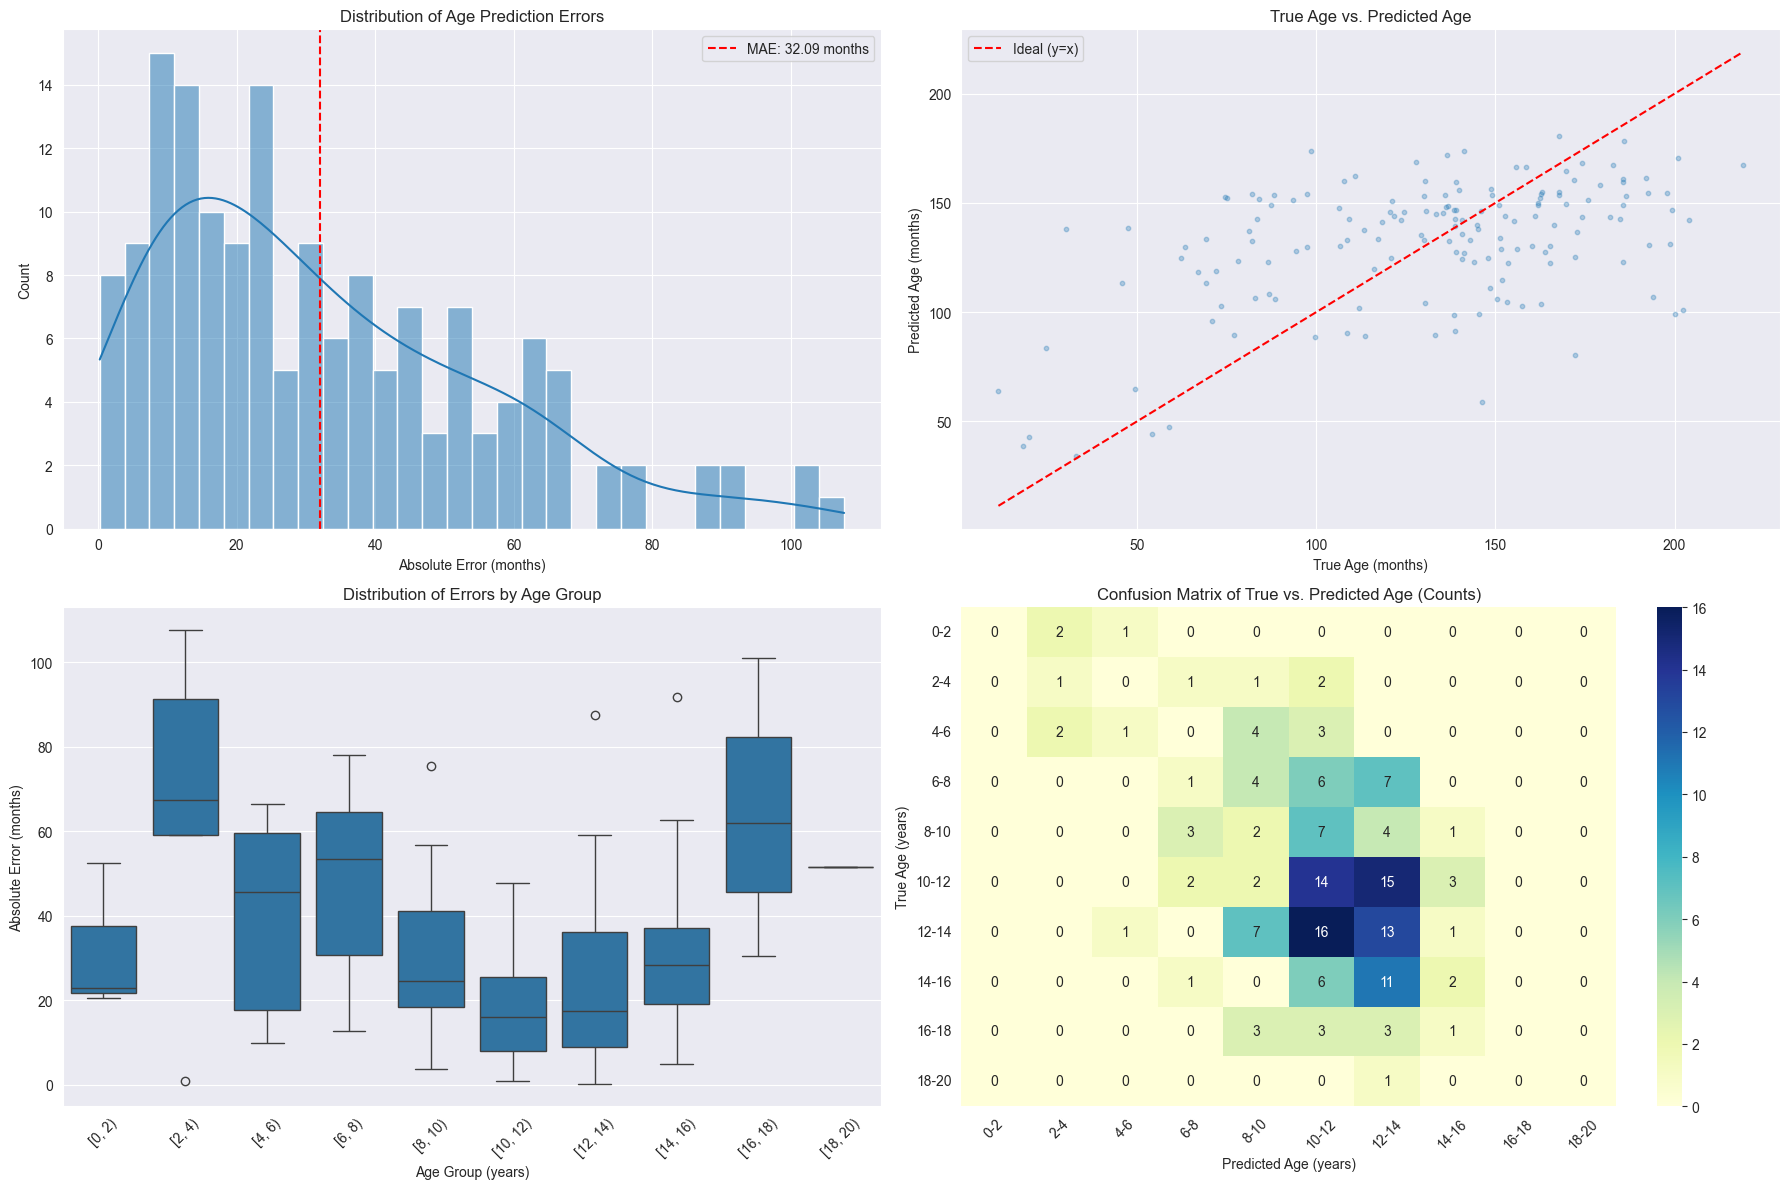

In [13]:
import seaborn as sns

def plot_eval(errors_list, mae_months, true_months_list, pred_months_list):
    """
    Generates and saves a series of unnormalized plots to analyze the
    performance of the age prediction model.

    Args:
        errors_list (list/array): List of absolute prediction errors (months).
        mae_months (float): Overall Mean Absolute Error (months).
        true_months_list (list/array): List of true ages (months).
        pred_months_list (list/array): List of predicted ages (months).
    """
    plt.figure(figsize=(18, 12))

    # 1. Distribution of absolute errors
    plt.subplot(2, 2, 1)
    sns.histplot(errors_list, kde=True, bins=30)
    plt.axvline(mae_months, color='r', linestyle='--', label=f'MAE: {mae_months:.2f} months')
    plt.xlabel('Absolute Error (months)')
    plt.ylabel('Count')
    plt.title('Distribution of Age Prediction Errors')
    plt.legend()

    # 2. Scatter plot: true age vs predicted age
    plt.subplot(2, 2, 2)
    plt.scatter(true_months_list, pred_months_list, alpha=0.3, s=10)
    # Ideal y=x line
    min_val = min(min(true_months_list), min(pred_months_list))
    max_val = max(max(true_months_list), max(pred_months_list))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y=x)')
    plt.xlabel('True Age (months)')
    plt.ylabel('Predicted Age (months)')
    plt.title('True Age vs. Predicted Age')
    plt.legend()
    plt.grid(True)

    # 3. Box plot of errors by age group (simplified binning)
    plt.subplot(2, 2, 3)
    # Create a DataFrame for plotting
    true_years = np.array(true_months_list) / 12
    error_df = pd.DataFrame({
        'Absolute_Error': errors_list,
        'Age_Group': pd.cut(true_years,
                            bins=np.arange(0, 21, 2), # Bins of 2 years (0-2, 2-4, etc.)
                            right=False,
                            include_lowest=True)
    })
    sns.boxplot(x='Age_Group', y='Absolute_Error', data=error_df)
    plt.xlabel('Age Group (years)')
    plt.ylabel('Absolute Error (months)')
    plt.title('Distribution of Errors by Age Group')
    plt.xticks(rotation=45)

    # 4. Heatmap: Raw counts of true vs predicted age groups (unnormalized)
    plt.subplot(2, 2, 4)
    pred_years = np.array(pred_months_list) / 12

    # Define bins for the heatmap, e.g., every 2 years
    max_age_val = np.ceil(max(true_years.max(), pred_years.max()))
    bins = np.arange(0, max_age_val + 2, 2)

    # Calculate the 2D histogram (raw counts)
    # We use pred_years for x-axis and true_years for y-axis
    counts, xedges, yedges = np.histogram2d(pred_years, true_years, bins=[bins, bins])

    # Create labels from bin edges
    tick_labels = [f'{int(b1)}-{int(b2)}' for b1, b2 in zip(bins[:-1], bins[1:])]

    # Plot the heatmap with raw counts. We transpose `counts` so that
    # the y-axis corresponds to true age and x-axis to predicted age.
    sns.heatmap(counts.T.astype(int), cmap='YlGnBu', annot=True, fmt="d",
                xticklabels=tick_labels,
                yticklabels=tick_labels)

    plt.ylabel('True Age (years)')
    plt.xlabel('Predicted Age (years)')
    plt.title('Confusion Matrix of True vs. Predicted Age (Counts)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig('bid_RNN_perf_unnormalized.png', dpi=300)
    plt.show()
plot_eval(abs_errors, mae_in_months, Y, P)